Importing libraries

In [23]:
!pip3 install torchaudio

In [24]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import math
import torch
import torchaudio as audio

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import librosa

import numpy as np

audio.set_audio_backend('sox_io')

connecting google disk

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


initializing values

In [4]:
energy_thresholds = [25, 85, 800, 800, 500, 100, 100, 200]
window_time = 0.01 # seconds
sample_rate = 16000 # 16 kHz
window_size = int(sample_rate * window_time)
hop_length = window_size // 2

function that loads audio file 

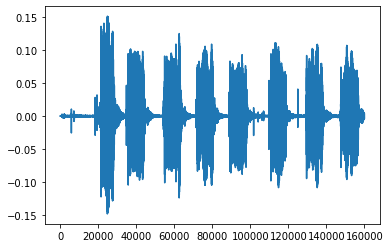

In [25]:
def load_samples(filepath):
    channels, sample_rate = audio.load(filepath, channels_first=True, normalize=True)
    return channels[0]

plt.plot(load_samples('/content/drive/MyDrive/positives/positives/positive-03.wav')[:16000 * 10])

function that calculates spectogram

In [6]:
sample_rate = 16000
window_time = 0.020 # seconds
window_size = int(sample_rate * window_time)
plt.figure(figsize=(16, 16))
spectogram = audio.transforms.Spectrogram(
    n_fft=window_size,
    win_length=window_size,
    hop_length=window_size,
    power=1
)
# samples = load_samples('/content/drive/MyDrive/positives/positives/positive-03.wav')
# plt.imshow(spectogram(samples)[:,:600])

<Figure size 1152x1152 with 0 Axes>

calculating energies for audio file

In [7]:
sample = load_samples('/content/drive/MyDrive/positives/positives/positive-03.wav')
energies = []

step = int(16000 * 20/1000)

for i in range(0, len(sample), step):
  subsample = sample[i : i+step]
  e = torch.pow(subsample, 2).mean()
  energies.append(e)

energies = torch.tensor(energies)

In [8]:
energies.shape

torch.Size([6082])

plotting energies vs log energies

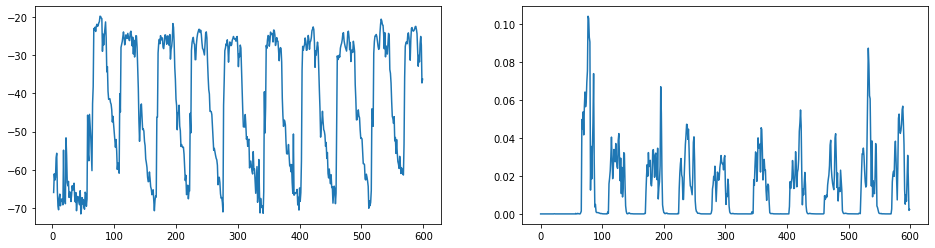

In [9]:
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(10*energies[:600].log10())
plt.subplot(122)
plt.plot(10*energies[:600])


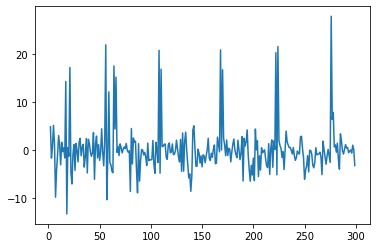

In [10]:

e_log = 10*energies.log10()
diff = e_log[1:] - e_log[:-1]
plt.plot(diff[:300])


РАЗМЕТКА ДАННЫХ

In [7]:
!pip3 install wavinfo

In [8]:
from wavinfo import WavInfoReader
from pathlib import Path
from pprint import pprint
import subprocess as sp
import numpy as np
import struct
import json
import sys
import re

SR = 16000
CHANNELS = 1
CODEC = "pcm_s16le"
SAMPLES_PATH = Path('/content/drive/MyDrive/alina_clean-2/samples')

FILE_PATTERNS = {
    'pos_clean': 'pos_clean_{}.wav',
    'pos_noisy': 'pos_noisy_{}.wav',
    'neg_clean': 'neg_clean_{}.wav',
    'neg_noisy': 'neg_noisy_{}.wav',
    'neg_random': 'neg_random_{}.wav',
}

FFPROBE_CMD = (
    "ffprobe -v quiet -print_format json "
    "-show_entries stream=duration,sample_rate,codec_name,channels {file}"
)
AUTOFIX_CMD = (
    f"ffmpeg -hide_banner -loglevel error -i {{input}} "
    f"-c:a {CODEC} -ar {SR} -ac {CHANNELS} -y {{output}}"
)

In [9]:
def validate_wav(path, autofix=False):
    cmd = FFPROBE_CMD.format(file=path)
    out = sp.check_output(cmd, shell=True, text=True)
    data = json.loads(out)["streams"][0]

    good = (
        data["codec_name"] == CODEC
        and int(data["sample_rate"]) == SR
        and data["channels"] == CHANNELS
    )

    if not good and autofix:
        output = path.parent / "autofix" / Path(file).name
        print(f"Autofixing {path} -> {output}")
        output.parent.mkdir(parents=True, exist_ok=True)
        cmd = AUTOFIX_CMD.format(input=file, output=output)
        sp.check_output(cmd, shell=True, text=True)
        data['autofix_path'] = output
    
    return good, data

def extract_wav_regions(path):
    with open(path, 'rb') as file:
        content = file.read()
    
    try:
        info = WavInfoReader(path)
        parent_chunks_dict = {x[0].decode("latin-1"): x for x in info.main_list}
    except Exception as err:
        # print('WavInfo error:', err)
        return None

    ok = "cue " in parent_chunks_dict and "adtl" in parent_chunks_dict
    if not ok:
        # print('Missing chunks (CUE, ADTL) in', path)
        return None

    offset = parent_chunks_dict["cue "].start
    length = struct.unpack_from('I', content, offset)[0]

    offset += 4
    cue_points = {}
    for i in range(length):
        id, pos, *_ = struct.unpack_from('IIIIII', content, offset)
        cue_points[id] = pos
        offset += 24

    region_chunks = parent_chunks_dict["adtl"].children
    regions = []
    for chunk in region_chunks:
        id, length, *_ = struct.unpack_from('IIIHHHH', content, chunk.start)
        regions.append((cue_points[id], cue_points[id] + length))

    return regions

In [10]:
bad = total = 0
for dir in SAMPLES_PATH.glob('*'):
    if not str(dir.name).isnumeric() or dir.is_file():
        continue
    print(f'Checking {dir}...')
    for file in dir.glob('*.wav'):
        good, data = validate_wav(file, autofix=True)
        total += 1
        if not good:
            print(f'Bad file: {file}')
            pprint(data, width=120, stream=sys.stderr)
            print(f'Autofix output:', data.get('autofix_path', None))
            bad += 1
            
print()
print('TOTAL SAMPLES:', total)
print('GOOD SAMPLES:', total - bad)
print('BAD SAMPLES:', bad)

Checking /content/drive/MyDrive/alina_clean-2/samples/3...
Checking /content/drive/MyDrive/alina_clean-2/samples/2...
Checking /content/drive/MyDrive/alina_clean-2/samples/5...
Checking /content/drive/MyDrive/alina_clean-2/samples/4...
Checking /content/drive/MyDrive/alina_clean-2/samples/0...
Checking /content/drive/MyDrive/alina_clean-2/samples/6...
Checking /content/drive/MyDrive/alina_clean-2/samples/1...

TOTAL SAMPLES: 52
GOOD SAMPLES: 52
BAD SAMPLES: 0


In [11]:
assert bad == 0

all_labels = {key: [] for key in FILE_PATTERNS}

for dir in SAMPLES_PATH.glob('*'):
    if not str(dir.name).isnumeric() or dir.is_file():
        continue
    print(f'\nProcessing {dir}...')
    files = list(dir.glob('*.wav'))
    for key, fmt in FILE_PATTERNS.items():
        pattern = re.compile(fmt.format('\d+'))
        filtered = [x for x in files if pattern.fullmatch(x.name)]
        if not filtered:
            print('Group not found:', key)
            continue
        
        regions = None
        if 'random' not in key:
            main_file = dir / fmt.format(0)
            regions = extract_wav_regions(main_file)
            if regions is None:
                if (dir / 'meta.json').exists():
                    with open(dir / 'meta.json') as file:
                        meta = json.load(file)
                        regions = meta[key]['labels']
                elif main_file.with_suffix('.npy').exists():
                    regions = np.load(main_file.with_suffix('.npy'))
                    regions = regions.tolist()
                else:
                    print('No regions found in', main_file)
                    continue
        
        for file in filtered:
            all_labels[key].append({
                'path': file.relative_to(SAMPLES_PATH).as_posix(),
                'regions': regions,
            })
        print(f'+ {len(filtered)} files -> {key}')


Processing /content/drive/MyDrive/alina_clean-2/samples/3...
No regions found in /content/drive/MyDrive/alina_clean-2/samples/3/pos_clean_0.wav
No regions found in /content/drive/MyDrive/alina_clean-2/samples/3/pos_noisy_0.wav
No regions found in /content/drive/MyDrive/alina_clean-2/samples/3/neg_clean_0.wav
No regions found in /content/drive/MyDrive/alina_clean-2/samples/3/neg_noisy_0.wav
+ 1 files -> neg_random

Processing /content/drive/MyDrive/alina_clean-2/samples/2...
+ 3 files -> pos_clean
+ 3 files -> pos_noisy
+ 3 files -> neg_clean
+ 3 files -> neg_noisy
+ 3 files -> neg_random

Processing /content/drive/MyDrive/alina_clean-2/samples/5...
+ 1 files -> pos_clean
+ 1 files -> pos_noisy
+ 1 files -> neg_clean
+ 1 files -> neg_noisy
+ 1 files -> neg_random

Processing /content/drive/MyDrive/alina_clean-2/samples/4...
+ 1 files -> pos_clean
Group not found: pos_noisy
+ 1 files -> neg_clean
Group not found: neg_noisy
+ 1 files -> neg_random

Processing /content/drive/MyDrive/alina

In [12]:
for key, items in all_labels.items():
    print('GROUP:', key)
    for item in items:
        print(item['path'])
    print()

print('TOTAL FILES IN GROUPS:')
for key in FILE_PATTERNS:
    print(key, '->', len(all_labels[key]))

path = SAMPLES_PATH / 'meta.json'
with open(path, 'w', encoding='utf-8') as file:
    json.dump(all_labels, file, ensure_ascii=False)
    
print('\nALL LABELS SAVED TO', path)

GROUP: pos_clean
2/pos_clean_2.wav
2/pos_clean_1.wav
2/pos_clean_0.wav
5/pos_clean_0.wav
4/pos_clean_0.wav
0/pos_clean_1.wav
0/pos_clean_2.wav
0/pos_clean_0.wav
6/pos_clean_0.wav
1/pos_clean_0.wav

GROUP: pos_noisy
2/pos_noisy_2.wav
2/pos_noisy_1.wav
2/pos_noisy_0.wav
5/pos_noisy_0.wav
0/pos_noisy_0.wav
0/pos_noisy_1.wav
0/pos_noisy_2.wav
6/pos_noisy_0.wav
1/pos_noisy_0.wav

GROUP: neg_clean
2/neg_clean_1.wav
2/neg_clean_2.wav
2/neg_clean_0.wav
5/neg_clean_0.wav
4/neg_clean_0.wav
0/neg_clean_1.wav
0/neg_clean_2.wav
0/neg_clean_0.wav
1/neg_clean_0.wav

GROUP: neg_noisy
2/neg_noisy_2.wav
2/neg_noisy_1.wav
2/neg_noisy_0.wav
5/neg_noisy_0.wav
0/neg_noisy_1.wav
0/neg_noisy_2.wav
0/neg_noisy_0.wav
1/neg_noisy_0.wav

GROUP: neg_random
3/neg_random_0.wav
2/neg_random_0.wav
2/neg_random_1.wav
2/neg_random_2.wav
5/neg_random_0.wav
4/neg_random_0.wav
0/neg_random_1.wav
0/neg_random_2.wav
0/neg_random_0.wav
1/neg_random_0.wav

TOTAL FILES IN GROUPS:
pos_clean -> 10
pos_noisy -> 9
neg_clean -> 9
ne

In [13]:
from pathlib import Path
import numpy as np
import librosa
import json
import sys

ROOT = Path('/content/drive/MyDrive/alina_clean-2').parent
SAMPLES_PATH = ROOT / 'alina_clean-2/samples'
META_PATH = SAMPLES_PATH / 'meta.json'
META = json.load(open(META_PATH))

print(
    'ALINA SAMPLES:',
    ', '.join((f'{k.upper()}: {len(v)}' for k, v in META.items())),
    file=sys.stderr,
)


def get_alina_sample(src, sr=16000):
    item = np.random.choice(META[src])
    path = SAMPLES_PATH / item['path']
    sig, _ = librosa.load(str(path), sr=sr)
    meta = {'src': src, 'path': str(path)}
    if item.get('regions') is not None:
        index = np.random.choice(np.arange(0, len(item['regions'])))
        meta['start'], meta['end'] = item['regions'][index]
    return sig, meta

ALINA SAMPLES: POS_CLEAN: 10, POS_NOISY: 9, NEG_CLEAN: 9, NEG_NOISY: 8, NEG_RANDOM: 10


In [14]:
import IPython.display as ipd

for key in all_labels:
    sig, meta = get_alina_sample(key, sr=SR)
    print(meta)
    
    start = meta.get('start', 0)
    end = meta.get('end', int(SR * 10))
    sig = sig[start:end]
    audio = ipd.Audio(data=sig, rate=SR)
    ipd.display(audio)

{'src': 'pos_clean', 'path': '/content/drive/MyDrive/alina_clean-2/samples/2/pos_clean_0.wav', 'start': 1182205, 'end': 1197281}


{'src': 'pos_noisy', 'path': '/content/drive/MyDrive/alina_clean-2/samples/2/pos_noisy_2.wav', 'start': 1063841, 'end': 1074941}


{'src': 'neg_clean', 'path': '/content/drive/MyDrive/alina_clean-2/samples/0/neg_clean_0.wav', 'start': 138591, 'end': 145782}


{'src': 'neg_noisy', 'path': '/content/drive/MyDrive/alina_clean-2/samples/5/neg_noisy_0.wav', 'start': 4526807, 'end': 4536584}


{'src': 'neg_random', 'path': '/content/drive/MyDrive/alina_clean-2/samples/2/neg_random_0.wav'}


МОДЕЛЬ

initialize some values

In [15]:
import math
# input_size = math.ceil(len(sample)/320)   # number of frames
input_size = 80
hidden_size = 128 

import libraries

In [16]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


initialize the model

In [17]:

class SumRNN(nn.Module):
    def __init__(self):
        super(SumRNN, self).__init__()
        self.rnn = torch.nn.GRUCell(input_size=input_size, hidden_size=hidden_size)
        self.linear = nn.Linear(hidden_size, 2) 
        
    def forward(self, x, h):
        h = self.rnn(x, h)
        return self.linear(h), h

initialize model, optimizer, loss function

In [18]:
model = SumRNN()
optimizer = torch.optim.RMSprop(model.parameters())
loss = nn.CrossEntropyLoss(weight=torch.Tensor([0, 100]))



In [19]:
!pip3 install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5887 sha256=8d6580809b56a36fb1586e7ea7f7d51c4f3ffb28da3c37d88fcd0a918f1ce909
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


ОБУЧАЕМ МОДЕЛЬ

In [93]:
# torch.save(model, '/content/drive/MyDrive/alina_clean-2/model')

In [94]:
model = torch.load('/content/drive/MyDrive/alina_clean-2/model')
model.eval()

SumRNN(
  (rnn): GRUCell(80, 128)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)

In [88]:
import IPython.display as ipd


positives = {'positives': ['/content/drive/MyDrive/alina_clean-2/samples/0/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/pos_clean_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/pos_clean_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/pos_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/pos_noisy_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/pos_noisy_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/1/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/1/pos_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/pos_clean_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/pos_clean_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/pos_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/pos_noisy_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/pos_noisy_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/3/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/3/pos_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/4/invalid_pos_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/4/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/5/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/5/pos_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/6/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/6/pos_noisy_0.wav',]}

negatives = {'negatives': ['/content/drive/MyDrive/alina_clean-2/samples/0/neg_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_clean_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_clean_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_noisy_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_noisy_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_random_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_random_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_random_2.wav',  '/content/drive/MyDrive/alina_clean-2/samples/1/neg_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/1/neg_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/1/neg_random_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_clean_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_clean_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_noisy_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_noisy_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_random_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_random_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_random_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/3/neg_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/3/neg_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/3/neg_random_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/4/invalid_neg_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/4/neg_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/4/neg_random_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/5/neg_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/5/neg_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/5/neg_random_0.wav',]}




while 1:


  input = torch.Tensor() 
  y_true = torch.Tensor()
  for key in all_labels: 
    sig, meta = get_alina_sample(key, sr=SR)
    start = meta.get('start', 0)
    end = meta.get('end', int(SR * 10))
    y = []



    if meta['path'] in positives.get('positives'):

      sample = load_samples(meta['path'])[start:end]

      matrix = spectogram(sample)[:80, :]
      y = torch.cat([torch.zeros(matrix.shape[1] - 15), torch.ones(10), torch.zeros(5)])

    else:
      sample = load_samples(meta['path'])[start:end]

      matrix = spectogram(sample)[:80, :]
      y = torch.zeros(matrix.shape[1])
  
    



    input = torch.cat((input, matrix), axis = 1)
    y_true = torch.cat((y_true, y))

  optimizer.zero_grad()

  h = torch.zeros(1, hidden_size, dtype=torch.float32) 

  predictiton = '' 
  error = 0
  
  for t in range(input.shape[1]): 
    feature_column = input[:, t] 
    feature_column = feature_column / torch.mean(feature_column) 
    feature_column = feature_column.view(1, -1)
    y_pred, h = model(feature_column, h)

    predictiton += str(y_pred.argmax())

    true_answer = y_true[t]

    true_answer = torch.Tensor([true_answer])

    error += loss(y_pred,  true_answer.long())

    
  error /= len(y_true)
  error.backward()
  optimizer.step()
  

  print(f'prediction {predictiton}, error={error.item():.4}') # prediction softmax #precision, recall 



prediction tensor(0)tensor(0)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(1)tensor(0)tensor(0)tensor(1)tensor(0)tensor(1)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0

KeyboardInterrupt: ignored

In [63]:
!pip3 install pytorch-ignite

     |████████████████████████████████| 204kB 3.9MB/s 


In [64]:
from ignite.metrics import Precision
from ignite.metrics import Recall

[Текст ссылки](https:// [Текст ссылки](https://))ТЕСТИРУЕМ МОДЕЛЬ 

In [89]:
import IPython.display as ipd
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
import torch.nn.functional as F



positives = {'positives': ['/content/drive/MyDrive/alina_clean-2/samples/0/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/pos_clean_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/pos_clean_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/pos_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/pos_noisy_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/pos_noisy_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/1/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/1/pos_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/pos_clean_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/pos_clean_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/pos_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/pos_noisy_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/pos_noisy_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/3/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/3/pos_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/4/invalid_pos_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/4/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/5/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/5/pos_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/6/pos_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/6/pos_noisy_0.wav',]}

negatives = {'negatives': ['/content/drive/MyDrive/alina_clean-2/samples/0/neg_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_clean_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_clean_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_noisy_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_noisy_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_random_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_random_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/0/neg_random_2.wav',  '/content/drive/MyDrive/alina_clean-2/samples/1/neg_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/1/neg_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/1/neg_random_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_clean_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_clean_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_noisy_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_noisy_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_random_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_random_1.wav', '/content/drive/MyDrive/alina_clean-2/samples/2/neg_random_2.wav', '/content/drive/MyDrive/alina_clean-2/samples/3/neg_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/3/neg_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/3/neg_random_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/4/invalid_neg_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/4/neg_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/4/neg_random_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/5/neg_clean_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/5/neg_noisy_0.wav', '/content/drive/MyDrive/alina_clean-2/samples/5/neg_random_0.wav',]}


precision = Precision()
recall = Recall()

for epoch in range(1, 10):
  
  with torch.no_grad():

    input = torch.Tensor() 
    y_true = torch.Tensor()


    for key in all_labels: 
      sig, meta = get_alina_sample(key, sr=SR)
      start = meta.get('start', 0)
      end = meta.get('end', int(SR * 10))
      y = []
  

      if meta['path'] in positives.get('positives'):

        sample = load_samples(meta['path'])[start:end]
  
        matrix = spectogram(sample)[:80, :]
        y = torch.cat([torch.zeros(matrix.shape[1] - 15), torch.ones(10), torch.zeros(5)])

      else:
        sample = load_samples(meta['path'])[start:end]
  
        matrix = spectogram(sample)[:80, :]
        y = torch.zeros(matrix.shape[1])

     

      input = torch.cat((input, matrix), axis = 1)
      y_true = torch.cat((y_true, y))


    h = torch.zeros(1, hidden_size, dtype=torch.float32) 
    # optimizer.zero_grad()

    predictiton = '' 
    error = 0

    for t in range(input.shape[1]): 
      feature_column = input[:, t] 
      feature_column = feature_column / torch.mean(feature_column) 
      feature_column = feature_column.view(1, -1)
      y_pred, h = model(feature_column, h)
  
      predictiton += str(y_pred.argmax())
  
      true_answer = y_true[t]
      true_answer = torch.Tensor([true_answer])

      precision.update((y_pred,  true_answer.long()))
      recall.update((y_pred,  true_answer.long()))
  

 
      
      
#        # error /= len(answer_array_test)
#        # error.backward()
#        # optimizer.step()

  print('epoch ended:')
  print("Precision: ", precision.compute()) #после каждой эпохи
  print("Recall: ", recall.compute()) #после каждой эпохи
    
  precision.reset()
  recall.reset()

      # error += loss(y_pred,  true_answer.long())




     

epoch ended:
Precision:  tensor([0.9471, 0.0233], dtype=torch.float64)
Recall:  tensor([0.2584, 0.5500], dtype=torch.float64)
epoch ended:
Precision:  tensor([0.9889, 0.1609], dtype=torch.float64)
Recall:  tensor([0.8801, 0.7000], dtype=torch.float64)
epoch ended:
Precision:  tensor([0.9707, 0.0331], dtype=torch.float64)
Recall:  tensor([0.3273, 0.7000], dtype=torch.float64)
epoch ended:
Precision:  tensor([1.0000, 0.0436], dtype=torch.float64)
Recall:  tensor([0.3619, 1.0000], dtype=torch.float64)
epoch ended:
Precision:  tensor([0.9887, 0.1239], dtype=torch.float64)
Recall:  tensor([0.8416, 0.7000], dtype=torch.float64)
epoch ended:
Precision:  tensor([0.9945, 0.1954], dtype=torch.float64)
Recall:  tensor([0.8851, 0.8500], dtype=torch.float64)
epoch ended:
Precision:  tensor([0.9939, 0.0405], dtype=torch.float64)
Recall:  tensor([0.2659, 0.9500], dtype=torch.float64)
epoch ended:
Precision:  tensor([0.9916, 0.0578], dtype=torch.float64)
Recall:  tensor([0.5603, 0.8500], dtype=torch.f

final testing

In [27]:
sample = load_samples('/content/drive/MyDrive/alina_clean-2/testing_alina.wav')

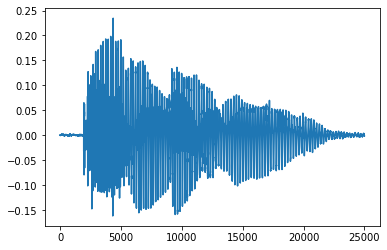

In [28]:
plt.plot(sample[270000:295000])

In [29]:
word_1 = [92500, 115000]
word_2 = [150000, 170000]
word_3 = [210000, 230000]
word_alina = [270000, 295000]

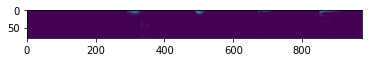

In [30]:
plt.imshow(spectogram(sample)[:80,:])


In [95]:
with torch.no_grad():

    input = torch.Tensor() 
    y_true = torch.Tensor()

    word = load_samples('/content/drive/MyDrive/alina_clean-2/testing_alina.wav')[word_1[0]:word_1[1]]

    matrix = spectogram(word)[:80, :]
    y = torch.zeros(matrix.shape[1])

    input = torch.cat((input, matrix), axis = 1)
    y_true = torch.cat((y_true, y))

    h = torch.zeros(1, hidden_size, dtype=torch.float32) 

    predictiton = '' 
    error = 0

    for t in range(input.shape[1]): 
      feature_column = input[:, t] 
      feature_column = feature_column / torch.mean(feature_column) 
      feature_column = feature_column.view(1, -1)
      y_pred, h = model(feature_column, h)
  
      predictiton += str(y_pred.argmax())
  
      true_answer = y_true[t]
      true_answer = torch.Tensor([true_answer])

     
    print(f'prediction {predictiton}') # prediction softmax #precision, recall 



prediction tensor(0)tensor(0)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(1)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(1)tensor(0)tensor(0)tensor(0)tensor(1)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(1)tensor(0)tensor(0)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(1)tensor(0)tensor(0)tensor(1)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(0)


In [91]:
with torch.no_grad():

    input = torch.Tensor() 
    y_true = torch.Tensor()

    word = load_samples('/content/drive/MyDrive/alina_clean-2/testing_alina.wav')[word_2[0]:word_2[1]]

    matrix = spectogram(word)[:80, :]
    y = torch.zeros(matrix.shape[1])

    input = torch.cat((input, matrix), axis = 1)
    y_true = torch.cat((y_true, y))

    h = torch.zeros(1, hidden_size, dtype=torch.float32) 

    predictiton = '' 
    error = 0

    for t in range(input.shape[1]): 
      feature_column = input[:, t] 
      feature_column = feature_column / torch.mean(feature_column) 
      feature_column = feature_column.view(1, -1)
      y_pred, h = model(feature_column, h)
  
      predictiton += str(y_pred.argmax())
  
      true_answer = y_true[t]
      true_answer = torch.Tensor([true_answer])

     
    print(f'prediction {predictiton}') # prediction softmax #precision, recall 



prediction tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)


In [92]:
with torch.no_grad():

    input = torch.Tensor() 
    y_true = torch.Tensor()

    word = load_samples('/content/drive/MyDrive/alina_clean-2/testing_alina.wav')[word_3[0]:word_3[1]]

    matrix = spectogram(word)[:80, :]
    y = torch.zeros(matrix.shape[1])

    input = torch.cat((input, matrix), axis = 1)
    y_true = torch.cat((y_true, y))

    h = torch.zeros(1, hidden_size, dtype=torch.float32) 

    predictiton = '' 
    error = 0

    for t in range(input.shape[1]): 
      feature_column = input[:, t] 
      feature_column = feature_column / torch.mean(feature_column) 
      feature_column = feature_column.view(1, -1)
      y_pred, h = model(feature_column, h)
  
      predictiton += str(y_pred.argmax())
  
      true_answer = y_true[t]
      true_answer = torch.Tensor([true_answer])

     
    print(f'prediction {predictiton}') # prediction softmax #precision, recall 



prediction tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)


In [77]:
with torch.no_grad():

    input = torch.Tensor() 
    y_true = torch.Tensor()

    word = load_samples('/content/drive/MyDrive/alina_clean-2/testing_alina.wav')[word_alina[0]:word_alina[1]]

    matrix = spectogram(word)[:80, :]
    y = torch.cat([torch.zeros(matrix.shape[1] - 15), torch.ones(10), torch.zeros(5)])

    input = torch.cat((input, matrix), axis = 1)
    y_true = torch.cat((y_true, y))

    h = torch.zeros(1, hidden_size, dtype=torch.float32) 

    predictiton = '' 
    error = 0

    for t in range(input.shape[1]): 
      feature_column = input[:, t] 
      feature_column = feature_column / torch.mean(feature_column) 
      feature_column = feature_column.view(1, -1)
      y_pred, h = model(feature_column, h)
  
      predictiton += str(y_pred.argmax())
  
      true_answer = y_true[t]
      true_answer = torch.Tensor([true_answer])

     
    print(f'prediction {predictiton}') # prediction softmax #precision, recall 



prediction tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(1)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(0)tensor(0)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(1)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)tensor(0)
